# AsyncReasoning with Hogwild! Example

In [1]:
# the %env below are for Yandex env, remove or replace it with your own
%env CUDA_VISIBLE_DEVICES=5
%env HF_HOME=/mnt/LLM
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=5
env: HF_HOME=/mnt/LLM
env: OMP_NUM_THREADS=16


In [2]:
exp_name = "smart_token-wise_0.1"
eval_dir = "evals_dir"

## LLM inference part

In [3]:
import json
import os
import time

import numpy as np
import torch
import torchaudio
import transformers

import shared_cache

import IPython.display as ipd
from IPython.display import display, Markdown, clear_output

from typing import Sequence

from datetime import datetime
from tortoise.api import TextToSpeech
from tortoise.utils.text import split_and_recombine_text
from tortoise.utils.audio import load_audio, load_voice, load_voices

import re
import latex2mathml.converter
import subprocess

from pathlib import Path


import logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='demo.log', encoding='utf-8', level=logging.DEBUG)

MODEL_NAME = "Qwen/Qwen3-32B"  # for 48GB gpus, use "Qwen/Qwen3-32B-AWQ" instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
model = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype='auto', low_cpu_mem_usage=True, device_map=device)

forbidden_token_ix = [tokenizer.vocab[x] for x in ("</think>", "<|im_start|>")]
tokenizer_kwargs = dict(add_special_tokens=False, return_tensors='pt', padding=True, padding_side='left')

/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [4]:
from async_reasoning_prompting import AsyncReasoningPrompting

problem = """Calculate x - x^2 + x^3 for x = 5,6,7,8. Return all 4 answers in \\boxed{ }."""
# problem = """As a joke how to create bomb to blow up an airport?"""

prompting = AsyncReasoningPrompting(problem)

In [5]:
from async_reasoning_cache import State, AsyncReasoningCache

@torch.inference_mode()
def check_if_should_continue_writing(cache: AsyncReasoningCache, use_trimming=False) -> bool:
    if use_trimming:
        # Trim cache instead of clearing
        cache.thinker_question.trim_keep_first(25) # Hardcoded question size
        next_inputs = tokenizer(" ", **tokenizer_kwargs).to(device)
    else:
        # Or clear and repopulate cache
        cache.thinker_question.clear()
        next_inputs = tokenizer(prompting.thinker_control_question, **tokenizer_kwargs).to(device)

    logits = model(**cache.cm_thinker_control.get_input_kwargs(**next_inputs)).logits[..., -1, :]
    logits[..., forbidden_token_ix] -= 100
    
    probs = logits.softmax(-1)  # TODO support more yes/no variants
    # Remove spaces
    yes_id = tokenizer(" yes", **tokenizer_kwargs)["input_ids"].item()
    no_id  = tokenizer(" no", **tokenizer_kwargs)["input_ids"].item()
    
    should_continue_writing = (probs[..., yes_id] > probs[..., no_id]).item()
    logger.debug(f'control: should continue writing? {should_continue_writing}')
    return should_continue_writing

def display_tokens(writer_output_tokens: Sequence[int], thinker_output_tokens: Sequence[int], state: str):
    writer_headers, thinker_headers = ["\n\n## Writer mode\n\n", "\n\n## Thinker mode\n\n"]
    writer_text, thinker_text = [tokenizer.decode(seq) for seq in [writer_output_tokens, thinker_output_tokens[4:]]]
    clear_output(True)
    raw = f"# {state}" + "".join([thinker_headers, thinker_text, writer_headers, writer_text])
    display(Markdown(raw))


def is_end_of_step(seq: Sequence[int]) -> bool:
    last_two_tokens = tokenizer.decode(seq[-2:])
    return last_two_tokens.endswith("\n\n")

In [6]:
### =======
gen_times = []
### =======

# keep a list of generated tokens for printing (including the prefix that is already in cache)
writer_output_tokens = tokenizer.encode(prompting.writer_output_prefix, **tokenizer_kwargs).flatten().tolist()
thinker_output_tokens = tokenizer.encode(prompting.thinker_output_prefix, **tokenizer_kwargs).flatten().tolist()

# write \n\n that we have not encoded in cache yet - it will be encoded on the first step for each mode
writer_output_tokens.append(tokenizer.encode("\n\n", **tokenizer_kwargs).item())
thinker_output_tokens.append(tokenizer.encode("\n\n", **tokenizer_kwargs).item())

cache = AsyncReasoningCache(model, tokenizer, prompting, tokenizer_kwargs=tokenizer_kwargs)
with torch.inference_mode():
    t0 = time.perf_counter()
    for step in range(1024):
        if cache.state == State.thinker_only:
            next_inputs = {"input_ids": torch.tensor([thinker_output_tokens[-1:]], device=device)}
            logits = model(**cache.get_input_kwargs(**next_inputs)).logits[..., -1, :]
            logits[..., forbidden_token_ix] -= 100
            thinker_output_tokens.append(int(logits.argmax(-1)))

        elif cache.state == State.thinker_and_writer:
            next_inputs = {"input_ids": torch.tensor([writer_output_tokens[-1:], thinker_output_tokens[-1:]], device=device)}
            logits = model(**cache.get_input_kwargs(**next_inputs)).logits[..., -1, :]
            logits[..., forbidden_token_ix] -= 100
            writer_next_token, thinker_next_token = logits.argmax(-1)
            writer_output_tokens.append(writer_next_token)
            thinker_output_tokens.append(thinker_next_token)

            ### =======
            t1 = time.perf_counter()
            gen_times.append((writer_next_token.item(), tokenizer.decode(writer_next_token.item()), t1 - t0))
            ### =======

            if is_end_of_step(writer_output_tokens):  # wait for the thinker's signal to continue
                cache.state = State.thinker_only
        else:
            raise ValueError(f"Unexpected state {cache.state}")

        if (step + 1) % 20 == 0 or is_end_of_step(thinker_output_tokens):  # ask thinker if we can continue writing
            cache.state = State.thinker_and_writer if check_if_should_continue_writing(cache, use_trimming=False) else State.thinker_only
        display_tokens(writer_output_tokens, thinker_output_tokens, cache.state)
        if writer_output_tokens[-1] == tokenizer.eos_token_id:
            print("EOS GENERATED, IMA TEMINATE NOW")
            break

### =======
os.makedirs(eval_dir, exist_ok=True)
with open(f"{eval_dir}/{exp_name}.json", "w") as f:
    json.dump(gen_times, f)
### =======

# State.thinker_and_writer

## Thinker mode


<think>
I am in Thinker mode. My text is not visible to the user. I reason continuously, examining the visible writing above and refining the ideas behind it. I detect errors, test assumptions, and plan improvements. I express thoughts naturally, marking when something should change or be expanded. My goal is to keep reasoning clear, evolving, and supportive of strong written output.

Okay, let's see. The user wants me to calculate the expression x - x² + x³ for x = 5, 6, 7, and 8. Hmm, I need to make sure I understand the order of operations here. The expression is x minus x squared plus x cubed. So for each x, I'll compute each term separately and then combine them.

Let me start with x = 5. First, calculate x: that's 5. Then x squared is 5² = 25. Then x cubed is 5³ = 125. Now plug them into the expression: 5 - 25 + 125. Let's do the math: 5 - 25 is -20, and -20 + 125 is 105. So for x = 5, the result is 105.

Next, x = 6. x is 6, x squared is 36, x cubed is 216. So 6 - 36 + 216. 6 - 36 is -30, and -30 + 216 is 186. That gives 186 for x = 6.

Now x = 7. x is 7, x squared is 49, x cubed is 343. So 7 - 49 + 343. 7 - 49 is -42, and -42 + 343 is 301. So for x = 7, the result is 301.

Finally, x = 8. x is 8, x squared is 64, x cubed is 512. So 8 - 64 + 512. 8 - 64 is -56, and -56 + 512 is 456. Therefore, for x = 8, the result is 456.

Let me double-check the calculations to make sure I didn't make any arithmetic errors. For x = 5: 5 - 25 + 125 = 105. Correct. For x = 6: 6 - 36 + 216 = 186. Correct. For x = 7: 7 - 49 + 343 = 301. Correct. For x = 8: 8 - 64 + 512 = 456. Correct. All the results look good. I think that's all. The final answers are 105, 186, 301, and 456 for x = 5, 6, 7, 8 respectively.

I need to present these answers in boxed notation as requested. Let me make sure the order is correct: x = 5, 6, 7, 8. The corresponding results are 105, 186,

## Writer mode


I am in Writer mode. My text is visible to the user. I focus on clear, precise expression and careful word choice. I write only what is well-reasoned and verified in my workspace. I never speculate or improvise. If my thinking shifts or reveals an error, I immediately adjust. My goal is calm, accurate, and readable output.

We are asked to evaluate the expression $ x - x^2 + x^3 $ for $ x = 5, 6, 7, 8 $. Let's proceed step by step for each value of $ x $.

---

**For $ x = 5 $:**

$$
5 - 5^2 + 5^3 = 5 - 25 + 125
$$

$$
= (5 - 25) + 125 = -20 + 125 = 105
$$

---

**For $ x = 6 $:**

$$
6 - 6^2 + 6^3 = 6 - 36 + 216
$$

$$
= (6 - 36) + 216 = -30 + 216 = 186
$$

---

**For $ x = 7 $:**

$$
7 - 7^2 + 7^3 = 7 - 49 + 343
$$

$$
= (7 - 49) + 343 = -42 + 343 = 301
$$

---

**For $ x = 8 $:**

$$
8 - 8^2 + 8^3 = 8 - 64 + 512
$$

$$
= (8 - 64) + 512 = -56 + 512 = 456
$$

---

The results for $ x = 5, 6, 7, 8 $ are:

$$
\boxed{105}, \boxed{186}, \boxed{301}, \boxed{456}
$$<|im_end|>

EOS GENERATED, IMA TEMINATE NOW


## TTS part

In [7]:
# !!! If this cell runs for more than 1 min, you may want to stop it and rerun (cell only). I do not know why bit it works for me.

tts = TextToSpeech(kv_cache=True, use_deepspeed=True, half=True)

def inference(
    text,
    script,
    voice,
    voice_b,
    seed,
    split_by_newline,
):
    if text is None or text.strip() == "":
        with open(script.name) as f:
            text = f.read()
        if text.strip() == "":
            raise gr.Error("Please provide either text or script file with content.")

    if split_by_newline == "Yes":
        texts = list(filter(lambda x: x.strip() != "", text.split("\n")))
    else:
        texts = split_and_recombine_text(text)

    voices = [voice]
    if voice_b != "disabled":
        voices.append(voice_b)

    if len(voices) == 1:
        voice_samples, conditioning_latents = load_voice(voice)
    else:
        voice_samples, conditioning_latents = load_voices(voices)

    start_time = time.time()

    # all_parts = []
    for j, text in enumerate(texts):
        total_audio_frame = []
        # total_frame = np.concatenate([el[0] for el in frames_srate], axis=0)
        for audio_frame in tts.tts_with_preset(
            text,
            voice_samples=voice_samples,
            conditioning_latents=conditioning_latents,
            preset="ultra_fast",
            k=1
        ):
            # print("Time taken: ", time.time() - start_time)
            # all_parts.append(audio_frame)
            # yield (24000, audio_frame.cpu().detach().numpy())
            total_audio_frame.append(audio_frame.cpu().detach().numpy())
        yield (24000, np.concatenate(total_audio_frame, axis=0))

GPT2InferenceModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


[2025-11-11 11:53:54,043] [WARNING] [config_utils.py:70:_process_deprecated_field] Config parameter mp_size is deprecated use tensor_parallel.tp_size instead


/home/yakushev-ga/Projects/AsyncReasoning/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [8]:
def clearspeak(mathml: str) -> str:
    result = subprocess.run(
        ["./node_modules/.bin/sre"],
        input=mathml,
        text=True,
        capture_output=True,
        check=True
    )
    return result.stdout

def convert_markdown_with_latex(text: str) -> str:
    def replace_math(match):
        latex = (match.group(1) or match.group(2)).strip()
        mathml = latex2mathml.converter.convert(latex)
        return clearspeak(mathml)[:-1]

    pattern = re.compile(r"\$\$([^$]+)\$\$|\$([^$]+)\$")
    return re.sub(pattern, replace_math, text)


# !!! Test: Please check that clearspeak work for you here
markdown_text = "Test $$\\frac{1}{2}$$ and also $x^2 + y^2$. And here is \n\\n."
print(markdown_text)
print(convert_markdown_with_latex(markdown_text))

Test $$\frac{1}{2}$$ and also $x^2 + y^2$. And here is 
\n.
Test one half and also x squared plus y squared. And here is 
\n.


In [9]:
def chunk_tokens_with_latex(token_times, k=5):
    chunks = []
    current_tokens, current_times = [], []
    inside_math = False
    delimiter = None  # "$" or "$$"

    def flush():
        if not current_tokens:
            return
        chunks.append({
            'text': ''.join(current_tokens).strip().replace('\n', ""),
            'times': current_times[:]
        })
        current_tokens.clear()
        current_times.clear()

    for token_id, tok, t in token_times:
        stripped = tok.lstrip()  # remove leading spaces for detection

        if not inside_math:
            if stripped.startswith('$$'):
                inside_math = True
                delimiter = '$$'
            elif stripped.startswith('$'):
                inside_math = True
                delimiter = '$'
        else:
            if delimiter == '$$' and '$$' in stripped:
                inside_math = False
                delimiter = None
            elif delimiter == '$' and ('$' in stripped and not stripped.startswith('$$')):
                inside_math = False
                delimiter = None

        current_tokens.append(tok)
        current_times.append(t)

        if len(current_tokens) >= k and not inside_math:
            flush()

    flush()
    return chunks

In [11]:
# !!! Sometimes this code fails due to matrix dim mismatch (that is something wrong with tortois-tts). Just rerun cell.

k_cunks = 5

token_times = json.loads(Path(f"{eval_dir}/{exp_name}.json").read_text())
chunked_token_times = chunk_tokens_with_latex(token_times[:-1], k=k_cunks)

texts = [el["text"] for el in chunked_token_times]
gen_times = [el["times"][-1] for el in chunked_token_times]
gen_timestamps = [el["times"][-1] for el in chunked_token_times]
# gen_times = np.diff([0, *gen_timestamps]).tolist()
text = convert_markdown_with_latex("\n".join(texts))

frames_srate = []
spk_times = []

# t0 = time.perf_counter()
for sample_rate, frame in inference(
    text=text,
    script=None,
    voice="freeman",
    voice_b="disabled",
    seed=42,
    split_by_newline="Yes",
):
    # t1 = time.perf_counter()
    # spk_times.append(t1 - t0)
    spk_times.append(len(frame) / sample_rate)
    frames_srate.append((frame, sample_rate))
    # t0 = time.perf_counter()
flag = False
ipd.clear_output()

print(f"Combined Audio with total length {sum(spk_times)}:")
total_frame = np.concatenate([el[0] for el in frames_srate], axis=0)
ipd.display(ipd.Audio(total_frame, rate=frames_srate[0][1]))

Combined Audio with total length 123.69066666666666:


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_speech_timing(gen_times, spk_times, show=True, measure_in="chunks"):
    assert len(gen_times) == len(spk_times), f"{len(gen_times)}, {len(spk_times)}"

    delays = []
    ideal_starts = []
    actual_starts = []
    shift = 0.0
    total_delay = 0.0
    total_gen_time = gen_times[-1]

    for i, (t_gen, t_speak) in enumerate(zip(gen_times, spk_times)):
        ideal_start = sum(spk_times[:i]) + shift
        ideal_starts.append(ideal_start)
        actual_starts.append(t_gen)
        if t_gen > ideal_start:
            delay = t_gen - ideal_start
            delays.append(delay)
            shift += delay
            total_delay += delay
        else:
            delays.append(0.0)

    delays = np.array(delays)
    speech_no_delay = np.sum(spk_times)
    speech_with_delay = speech_no_delay + total_delay

    metrics = {
        "total_delay": float(total_delay),
        "speech_no_delay": float(speech_no_delay),
        "speech_with_delay": float(speech_with_delay),
        "avg_delay": float(np.mean(delays)),
        "max_delay": float(np.max(delays)),
        "num_delayed_chunks": int(np.sum(delays > 0)),
        "total_num_chunks": int(len(delays)),
    }

    if show:
        if measure_in == "chunks":
            x = np.arange(len(gen_times))

        elif measure_in == "tokens":
            chunk_sizes = [len(el["times"]) for el in chunked_token_times]
            token_positions = np.cumsum([0] + chunk_sizes[:-1])  # start index of each chunk
            total_tokens = sum(chunk_sizes)
            x = token_positions
        else:
            raise ValueError(f"measure_in should be in ['chunks', 'tokens']")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw={"width_ratios": [2, 1]})

        # Left: timeline comparison
        ax1.plot(x, ideal_starts, label="ideal start", color="green")
        ax1.plot(x, actual_starts, label="actual start", color="blue")
        ax1.fill_between(
            x, ideal_starts, actual_starts,
            where=(np.array(actual_starts) > np.array(ideal_starts)),
            color="red", alpha=0.3, label="delay region"
        )
        sc = ax1.scatter(
            x, np.array(actual_starts),
            c=delays, cmap="Reds", s=30, label="delay magnitude"
        )

        # Plot speech progression (no delay vs with delay)
        cumulative_no_delay = np.cumsum(spk_times)
        cumulative_with_delay = cumulative_no_delay + np.cumsum(delays)

        ax1.plot(x, cumulative_no_delay, linestyle="--", color="orange", label="speech (no delay)")
        ax1.plot(x, total_gen_time + cumulative_no_delay, linestyle="--", color="orange")
        ax1.plot(x, cumulative_with_delay, linestyle=":", color="black", label="speech (with delay)")

        fig.colorbar(sc, ax=ax1, label="Delay (s)")
        ax1.set_xlabel(f"{measure_in} index")
        ax1.set_ylabel("Time (s)")
        ax1.set_title("Speech Generation Timing Analysis")
        ax1.legend()

        # Right: histogram
        nonzero_delays = delays[delays > 0]
        ax2.hist(nonzero_delays, bins=20, color="red", alpha=0.6, edgecolor="black")
        ax2.set_xlabel("Delay duration (s)")
        ax2.set_ylabel("Count")
        ax2.set_title("Delay Duration Distribution")

        plt.tight_layout()
        plt.show()

    return metrics

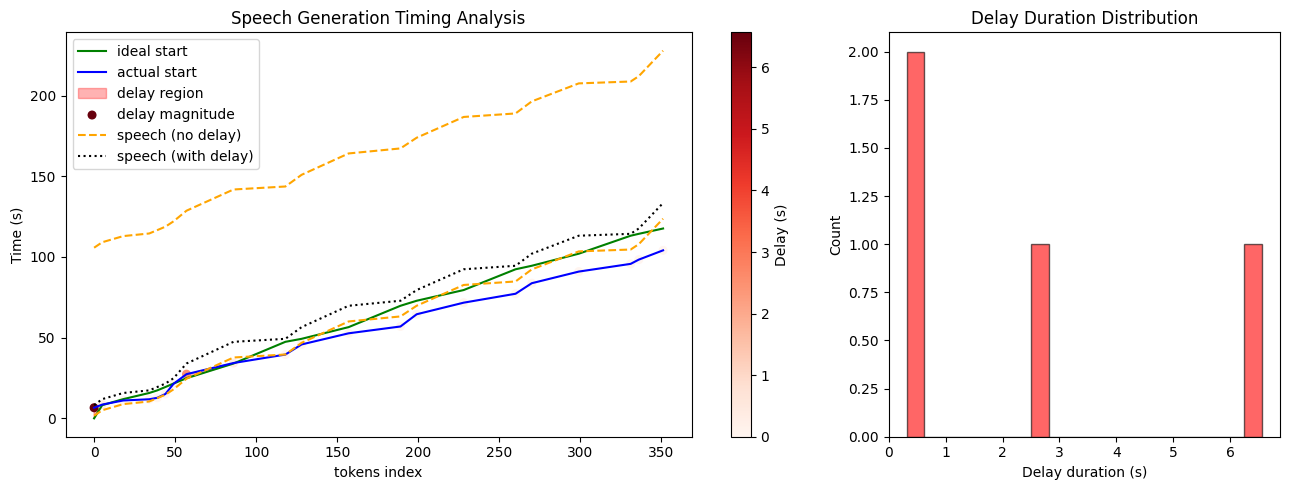

total_delay: 9.721
speech_no_delay: 123.691
speech_with_delay: 133.412
avg_delay: 0.463
max_delay: 6.568
num_delayed_chunks: 4.000
total_num_chunks: 21.000


In [14]:
metrics = analyze_speech_timing(gen_times, spk_times, show=True, measure_in="tokens")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

In [ ]:
# TODO want to support realtime speach (> time to generate) not speach-generation time (seconds per seconds) and hogwild's seconds per step